In [28]:
############ LOAD in custom packages ################
import sys
import os
import pandas as pd
import numpy as np
import importlib
from fastdtw import dtw
import seaborn as sns
import matplotlib.pyplot as plt

# Get the absolute path of the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Define data directory
brighten_dir = os.path.join(project_root, 'BRIGHTEN_data')

# Add project root to sys.path
sys.path.append(project_root)

# Import and reload custom scripts
from scripts import preprocessing as pre
from scripts import visualization as vis
from scripts import feature_selection as fs
from scripts import clustering as cl
from scripts import variables as var
importlib.reload(pre)
importlib.reload(vis)
importlib.reload(fs)
importlib.reload(cl)
importlib.reload(var)

################ DEFINE column variables from data ###################
from scripts.variables import id_columns, demographic_columns, daily_cols_v1, daily_v2_common 
from scripts.variables import phq2_cols, phq9_cols, weekly_cols, passive_cols, survey_cols, daily_v2_weather
from scripts.variables import df_names, df_mis, df_names_with_mis
demo_df = pd.read_csv(os.path.join(brighten_dir, f'demographics.csv'))
demographic_vars = [col for col in demo_df.columns if col!='num_id']
print(demographic_vars)
id_columns.append('idx')


['Unnamed: 0', 'phq9_1_base', 'phq9_2_base', 'phq9_3_base', 'phq9_4_base', 'phq9_5_base', 'phq9_6_base', 'phq9_7_base', 'phq9_8_base', 'phq9_9_base', 'phq9_sum_base', 'gender', 'education', 'working', 'income_satisfaction', 'income_lastyear', 'marital_status', 'race', 'age', 'screen_1', 'screen_2', 'screen_3', 'screen_4', 'bipolar', 'scz', 'alc_1', 'alc_2', 'alc_3', 'alc_sum', 'gad7_1', 'gad7_2', 'gad7_3', 'gad7_4', 'gad7_5', 'gad7_6', 'gad7_7', 'gad7_8', 'gad7_sum', 'mhs_1', 'mhs_2', 'mhs_3', 'mhs_4', 'mhs_5', 'mhs_sum', 'bin_clin']


## First, remove skewed variables

In [30]:
## Investigate kurtosis and skewedness
for name in df_names:
    df = pd.read_csv(os.path.join(brighten_dir, f'{name}_clean.csv'))
    print(f'\n\nFor {name}:')
    numeric_cols = [col for col in df.columns.to_list() if col not in id_columns and col not in demographic_vars]
    non_bin_cols = [col for col in numeric_cols if '_bin' not in col and "_indicator" not in col and "_missing" not in col]
    skew_list = df[non_bin_cols].skew(numeric_only=True).sort_values(ascending=False) # sort by highest, display    
    if len(skew_list[skew_list > 1])>0:
        print(f'Of {len(skew_list)} measures, these measures have skew > 1:')
        print(skew_list[skew_list > 1])

for name in df_names:
    df = pd.read_csv(os.path.join(brighten_dir, f'{name}_clean.csv'))
    print(f'\n\nFor {name}:')
    numeric_cols = [col for col in df.columns.to_list() if col not in id_columns and col not in demographic_vars]
    non_bin_cols = [col for col in numeric_cols if '_bin' not in col and "_indicator" not in col and "_missing" not in col]

    # Calculate kurtosis for numeric columns
    kurtosis_vals = df[non_bin_cols].kurtosis(numeric_only=True)
    kurtosis_sorted = kurtosis_vals.sort_values(ascending=False) # Sort by highest kurtosis
    
    if len(kurtosis_sorted[kurtosis_sorted > 2])>0:
        print(f'Of {len(kurtosis_sorted)} measures, these measures have Kurtosis > 2:')
        print(kurtosis_sorted[kurtosis_sorted > 2]) #display

    if len(kurtosis_sorted[kurtosis_sorted.isna()])>0:
        print('These columns have NaN in Kurtosis:')
        print(kurtosis_sorted[kurtosis_sorted.isna()]) #display

    # More investigation into kurtosis NaN values
    for col in kurtosis_sorted[kurtosis_sorted.isna()].index:
        print(f'Kurtosis is NaN for {col}:')
        if col in df.columns:
            print('Unique values:', df[col].nunique())      # Unique values
            print("Missing values:", df[col].isna().sum())   # Missing values
            print("Variance:", df[col].var())     # Summary stats



For v1_day:
Of 12 measures, these measures have skew > 1:
unreturned_calls       2.361195
missed_interactions    1.993468
dtype: float64


For v2_day:
Of 15 measures, these measures have skew > 1:
hours_walking_hr            2.486482
hours_powered_vehicle_hr    1.899404
hours_of_sleep_hr           1.528933
phq2_sum                    1.512557
phq2_2                      1.460523
hours_active_hr             1.328025
dtype: float64


For v1_week:


For v2_week:
Of 24 measures, these measures have skew > 1:
phq9_9                      1.790672
hours_powered_vehicle_hr    1.225971
dtype: float64


For v1_day:
Of 12 measures, these measures have Kurtosis > 2:
sms_length                 5.659865
unreturned_calls           4.493248
interaction_diversity      3.530725
aggregate_communication    3.073531
missed_interactions        2.918206
call_duration              2.201903
dtype: float64


For v2_day:
Of 15 measures, these measures have Kurtosis > 2:
hours_walking_hr            7.179408
hou

may 7 -- too much skew in many variables.. ?

In [ ]:
for name in df_names:
    df = pd.read_csv(os.path.join(brighten_dir, f'{name}_clean.csv'))

    df_unskewed = df.copy()
    if name == "v1_day":
        df_unskewed = df_unskewed.drop(columns=['unreturned_calls','missed_interactions','interaction_diversity','aggregate_communication'])
    if name == "v2_day":
        df_unskewed = df_unskewed.drop(columns=['hours_walking_hr','hours_powered_vehicle_hr','hours_of_sleep_hr','hours_active_hr','location_variance_hr','hours_stationary_hr'])
    # if name == "v1_week":
    #     df_unskewed = df_unskewed.drop(columns=[])
    if name == "v2_week":
        df_unskewed = df_unskewed.drop(columns=['precip_sum','phq9_9','phq9_8', 'distance_active_hr','precip_sum','distance_active_hr','distance_powered_vehicle_hr','distance_walking_hr'])
    if 'Unnamed: 0' in df_unskewed.columns:
        df_unskewed = df_unskewed.drop(columns=['Unnamed: 0'])
    df_unskewed.to_csv(os.path.join(brighten_dir, f'{name}_clean_unskewed.csv'))
    print(f'Saved {name}_unskewed to brighten_dir')


Saved v1_day_unskewed to brighten_dir


KeyError: "['precip_sum'] not found in axis"



DATAFRAME: v1_day
In df there are 372 subjects.


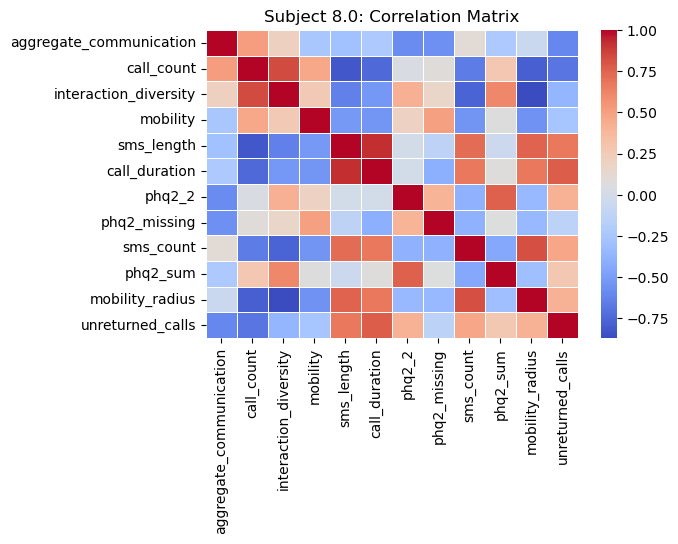

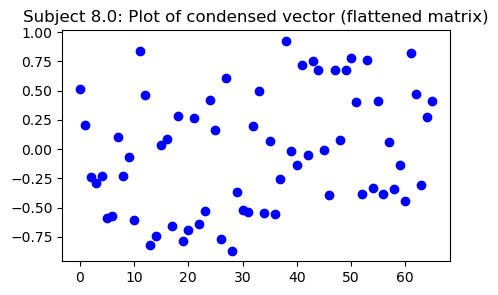

372 subs with symptom matrices
372 filled condensed arrays


DATAFRAME: v2_day
In df there are 16 subjects.


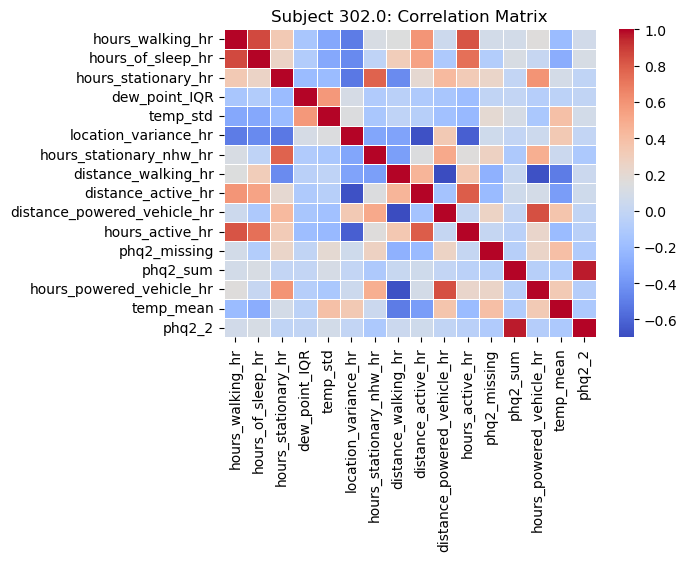

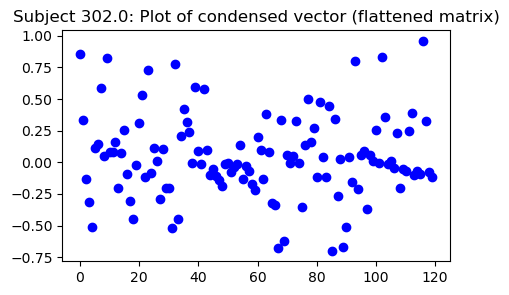

16 subs with symptom matrices
16 filled condensed arrays


DATAFRAME: v1_week
In df there are 113 subjects.


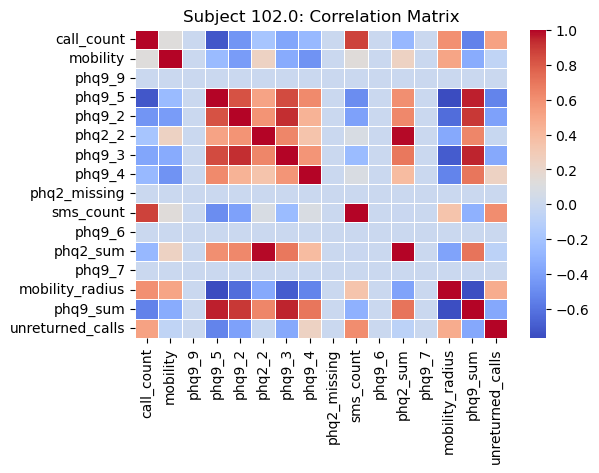

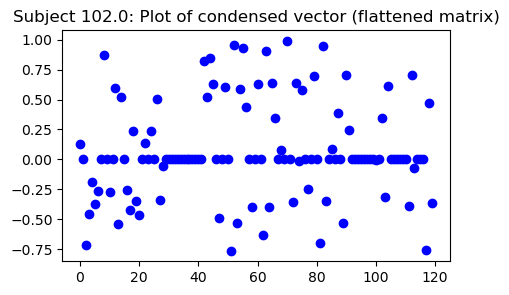

95 subs with symptom matrices
95 filled condensed arrays


DATAFRAME: v2_week
In df there are 15 subjects.


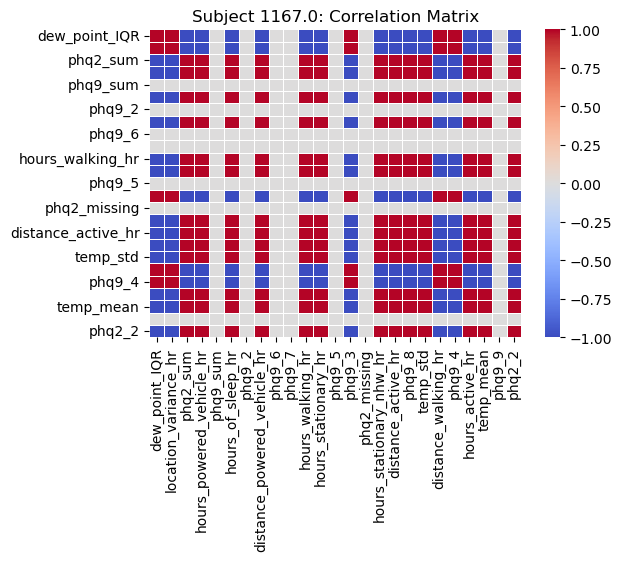

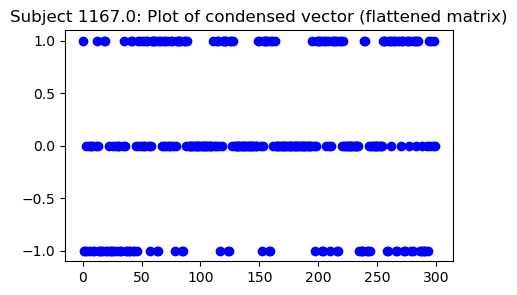

10 subs with symptom matrices
10 filled condensed arrays


In [ ]:
#### Take the average of each subject's symptom correlation and use it to make clusters of variables
symptom_matrices_df_dict = {}
flattened_matrices_df_dict = {}
target_cols = phq2_cols+phq9_cols

# Create dicts of all subjects' correlation matrices
for name in df_names:
    df = pd.read_csv(os.path.join(brighten_dir, f'{name}_clean.csv'))
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    df = df.loc[:, ~df.columns.str.contains('_int')]
    print(f'\n\nDATAFRAME: {name}')
    ignore_cols = [col for col in df.columns if col in demographic_vars+id_columns or "_indicator" in col or "_bin" in col]
    symptom_matrix_dict, flattened_matrix_dict = fs.make_symptom_matrices(df, ignore_cols, num_to_plot=1)
    symptom_matrices_df_dict[name] = symptom_matrix_dict
    flattened_matrices_df_dict[name] = flattened_matrix_dict



/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


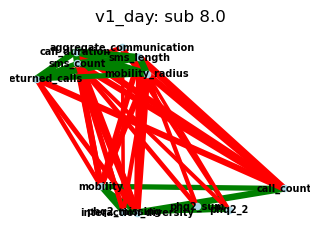

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


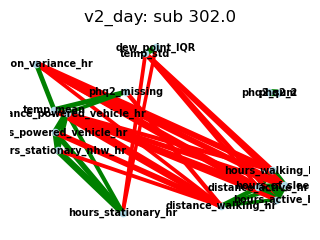

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


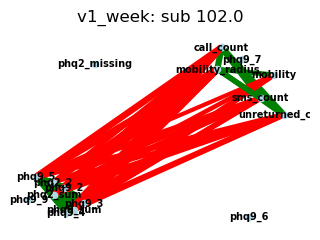

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


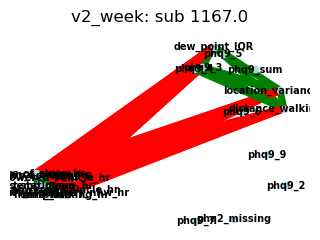

In [15]:
############### Plot individual networks of symptom matrices #################

for name, df_dict in symptom_matrices_df_dict.items():
    count=0
    for sub, corr_matrix in df_dict.items():
        if count<1:
            fs.plot_network(corr_matrix, title=f'{name}: sub {sub}')
            count=+1

In [9]:
# Double check where 'labels' are for columns
symptom_matrices_df_dict['v1_day'][list(symptom_matrices_df_dict['v1_day'].keys())[0]].index

Index(['phq9_2_base', 'phq9_sum_base', 'call_count', 'marital_status',
       'phq9_9_base', 'scz', 'phq2_sum', 'phq2_sum_indicator', 'call_duration',
       'gad7_5', 'working', 'alc_sum', 'unreturned_calls', 'alc_3', 'gad7_2',
       'gad7_sum', 'gad7_8', 'unreturned_calls_indicator', 'income_lastyear',
       'phq9_8_base', 'sms_length_indicator', 'phq9_5_base', 'bin_clin',
       'aggregate_communication', 'sms_length', 'screen_2',
       'interaction_diversity_indicator', 'phq9_4_base',
       'interaction_diversity', 'phq9_7_base', 'gad7_3', 'phq2_2',
       'sms_count_indicator', 'phq2_2_indicator', 'screen_4', 'mhs_3',
       'gad7_4', 'mobility_radius_indicator', 'phq9_6_base',
       'call_count_indicator', 'mhs_4', 'aggregate_communication_indicator',
       'screen_3', 'alc_2', 'mhs_5', 'bipolar', 'phq2_missing',
       'mobility_radius', 'mhs_sum', 'mobility', 'gad7_7',
       'call_duration_indicator', 'phq9_3_base', 'mhs_2', 'sms_count',
       'gad7_6', 'income_satisfac

Ok so temp mean and dew point IQR keep having relatively high correlations with the target variables, so we'll keep these, and drop the rest of the weather variables. Humidity also does but since it's highyl correlated with temp, we'll keep it out. 

In [16]:
for name in df_names:
    if 'v2' in name:
        df = pd.read_csv(os.path.join(brighten_dir, f'{name}_res.csv'))
        keep = ['temp_mean', 'temp_std', 'dew_point_IQR']
        cols_to_drop = [col for col in df.columns if col in daily_v2_weather and col not in keep]
        print(f"For {name} dropping {cols_to_drop}")
        df2 = df.drop(columns=cols_to_drop)
        df2.to_csv(os.path.join(brighten_dir, f'{name}_dropped.csv'))
        df2 = df2.loc[:, ~df2.columns.str.contains('^Unnamed')]  
        df2 = df2.loc[:, ~df2.columns.str.contains('.1')]  
        df_clean = df2.dropna()
        print(f'{name}, Shape of df {df2.shape}, shape of clean df {df_clean.shape}')
        df_clean.to_csv(os.path.join(brighten_dir, f"{name}_clean.csv"))


For v2_day dropping ['cloud_cover_mean', 'dew_point_mean', 'humidity_mean', 'humidity_IQR', 'temp_IQR', 'cloud_cover_IQR', 'cloud_cover_std', 'dew_point_std', 'humidity_std', 'cloud_cover_median', 'dew_point_median', 'humidity_median', 'temp_median', 'precip_sum']
v2_day, Shape of df (1212, 91), shape of clean df (1212, 91)
For v2_week dropping ['cloud_cover_mean', 'dew_point_mean', 'humidity_mean', 'humidity_IQR', 'temp_IQR', 'cloud_cover_IQR', 'cloud_cover_std', 'dew_point_std', 'humidity_std', 'cloud_cover_median', 'dew_point_median', 'humidity_median', 'temp_median', 'precip_sum']
v2_week, Shape of df (77, 111), shape of clean df (77, 111)


v1_day
(12, 12) variables included


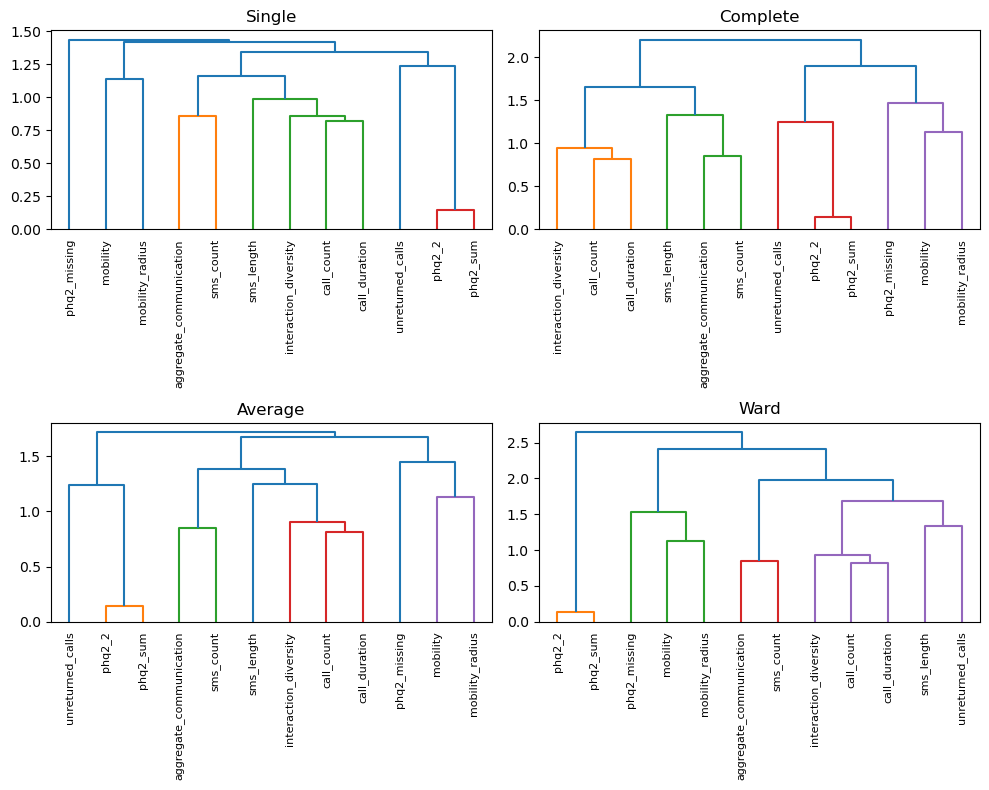

v2_day
(16, 16) variables included


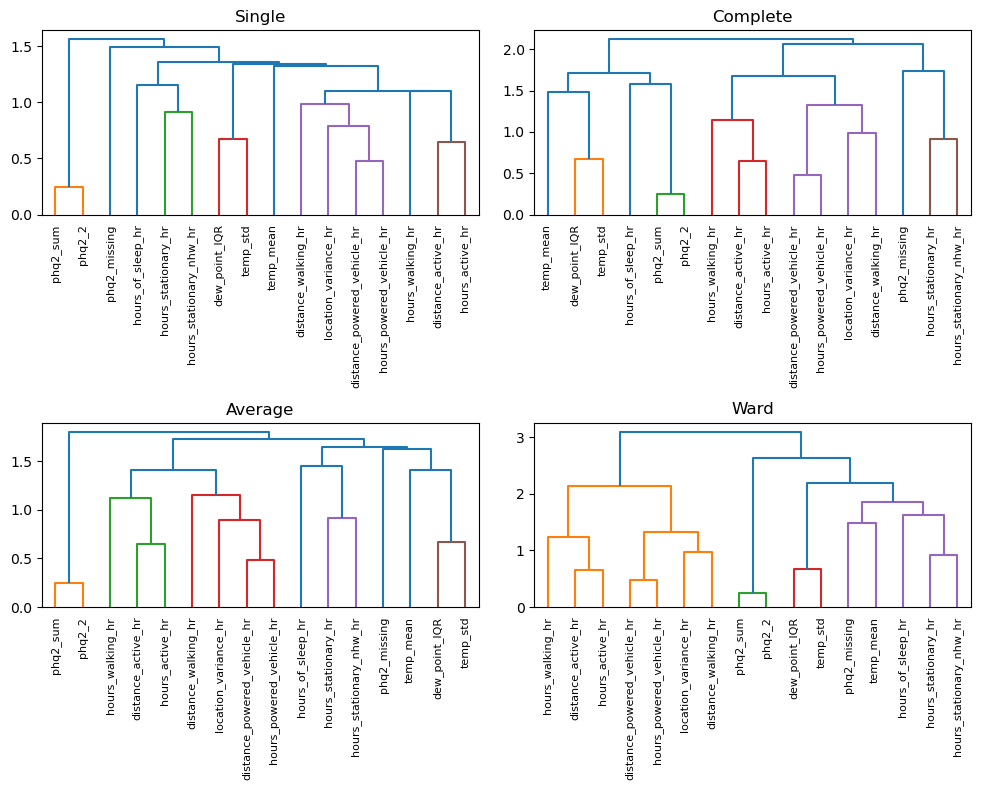

v1_week
(16, 16) variables included


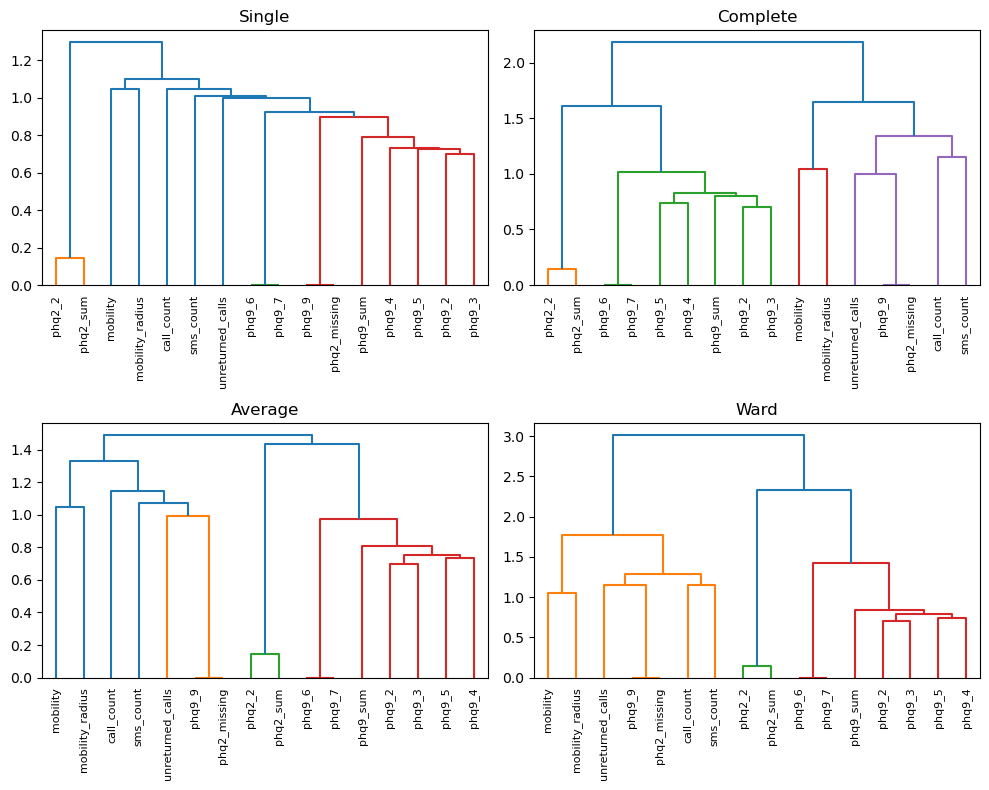

v2_week
(25, 25) variables included


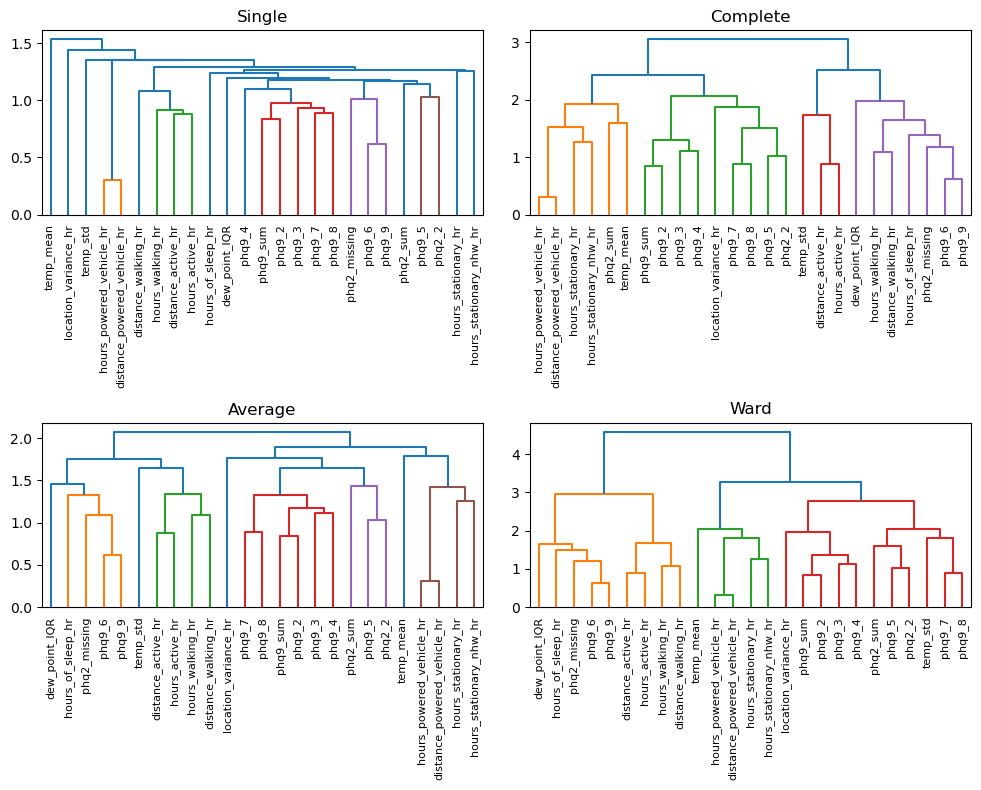

In [17]:
## Plot options
for name, df in symptom_matrices_df_dict.items():
    avg_matrix = fs.average_matrix(df)
    fs.plot_hier_agg(avg_matrix, df[list(df.keys())[0]].index, is_dict=False, group_title=f'{name}') # 3, ward


### Mark down best fits:
* v1_day -> 4, average
* v1_week -> 5, average
* v2_day -> 12, single (seems like a lot of noise)  
* v2_week ->

In [18]:
################# Create cluster_dict of Variables + Cluster Labels ############

clust_dict = {}
# clust_dict['v1_day'] = v1_day_clust_dict
for name, dictionary in symptom_matrices_df_dict.items():
    avg_matrix = fs.average_matrix(dictionary)
    if 'v1_day' in name:
        clust_dict[name] = fs.hier_agg_clustering(avg_matrix, dictionary[list(dictionary.keys())[0]].index, n_clusters=5, linkage='single', is_dict=False)
    if 'v2_day' in name:
       clust_dict[name] = fs.hier_agg_clustering(avg_matrix, dictionary[list(dictionary.keys())[0]].index, n_clusters=6, linkage='average', is_dict=False)
    if 'v1_week' in name:
        clust_dict[name] = fs.hier_agg_clustering(avg_matrix, dictionary[list(dictionary.keys())[0]].index, n_clusters=5, linkage='average', is_dict=False)
    if 'v2_week' in name:
       clust_dict[name] = fs.hier_agg_clustering(avg_matrix, dictionary[list(dictionary.keys())[0]].index, n_clusters=6, linkage='average', is_dict=False)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:586: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


In [19]:
################# Create df_pca of Variables + 1st PC of clusters Labels ############

dfs_pca = {}
dfs_pca_dict = {}
for name in df_names:
    df_scaled = pd.read_csv(os.path.join(brighten_dir, f'{name}_res.csv'))
    print(f'\nFor {name}')
    dfs_pca[name], dfs_pca_dict[name] = fs.pca_on_clusters(df_scaled, clust_dict[name], n_clusters=6) #n_clusters = number shown, so choose max



For v1_day
Cols for cluster 0: ['aggregate_communication', 'call_count', 'call_duration', 'interaction_diversity', 'sms_count', 'sms_length']
Cols for cluster 1: ['phq2_2', 'phq2_sum']
Cols for cluster 2: ['mobility', 'mobility_radius']
Cols for cluster 3: ['phq2_missing']
Cols for cluster 4: ['unreturned_calls']
Skipping cluster 5: No variables assigned.

For v2_day
Cols for cluster 0: ['temp_mean', 'dew_point_IQR', 'temp_std']
Cols for cluster 1: ['hours_stationary_hr', 'hours_stationary_nhw_hr']
Cols for cluster 2: ['distance_walking_hr', 'hours_active_hr', 'distance_active_hr', 'distance_powered_vehicle_hr', 'hours_powered_vehicle_hr', 'hours_walking_hr', 'location_variance_hr']
Cols for cluster 3: ['phq2_2', 'phq2_sum']
Cols for cluster 4: ['phq2_missing']
Cols for cluster 5: ['hours_of_sleep_hr']

For v1_week
Cols for cluster 0: ['sms_count', 'unreturned_calls', 'phq9_9', 'phq2_missing']
Cols for cluster 1: ['mobility', 'mobility_radius']
Cols for cluster 2: ['phq2_2', 'phq2_sum

In [ ]:
# # Name the clusters
dfs_pca_dict['v1_day'][0]['name'] = 'pc_communications'
dfs_pca_dict['v1_day'][1]['name'] = 'pc_phq2'
dfs_pca_dict['v1_day'][2]['name'] = 'pc_mobility'
dfs_pca_dict['v1_day'][3]['name'] = 'pc_phq2_missing'
dfs_pca_dict['v1_day'][4]['name'] = 'pc_unreturned_calls'

dfs_pca_dict['v2_day'][0]['name'] = 'pc_temp'
dfs_pca_dict['v2_day'][1]['name'] = 'pc_stationary'
dfs_pca_dict['v2_day'][2]['name'] = 'pc_active'
dfs_pca_dict['v2_day'][3]['name'] = 'pc_phq2'
dfs_pca_dict['v2_day'][4]['name'] = 'pc_phq2_missing'
dfs_pca_dict['v2_day'][5]['name'] = 'pc_hours_of_sleep'

dfs_pca_dict['v1_week'][0]['name'] = 'pc_missing'
dfs_pca_dict['v1_week'][1]['name'] = 'pc_mobility'
dfs_pca_dict['v1_week'][2]['name'] = 'pc_phq2'
dfs_pca_dict['v1_week'][3]['name'] = 'pc_phq9'
dfs_pca_dict['v1_week'][4]['name'] = 'pc_calls'

dfs_pca_dict['v2_week'][0]['name'] = 'pc_phq9'
dfs_pca_dict['v2_week'][1]['name'] = 'pc_activity'
dfs_pca_dict['v2_week'][2]['name'] = 'pc_dewpoint'
dfs_pca_dict['v2_week'][3]['name'] = 'pc_phq2'
dfs_pca_dict['v2_week'][4]['name'] = 'pc_stationary'
dfs_pca_dict['v2_week'][5]['name'] = 'pc_sleep'


for name in df_names:
    df_scaled = pd.read_csv(os.path.join(brighten_dir, f'{name}_clean.csv'))
    dfs_pca[name] = fs.merge_df_via_cluster_pca_dict(df_scaled, dfs_pca_dict[name], on_columns=['num_id', 'dt', 'week'])
    dfs_pca[name].to_csv(os.path.join(brighten_dir, f'{name}_pca.csv'), index=False)




/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


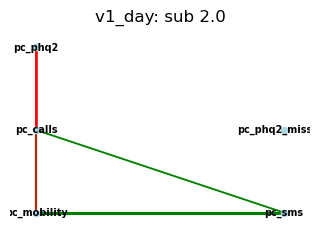

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


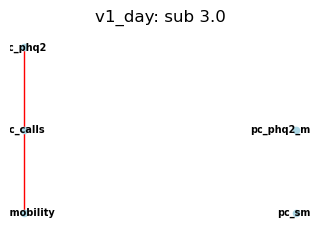

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


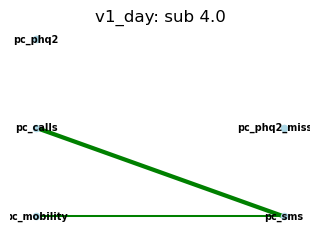

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


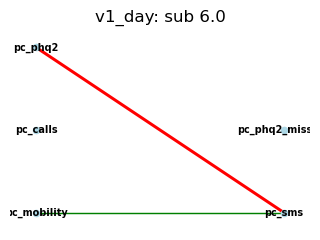

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


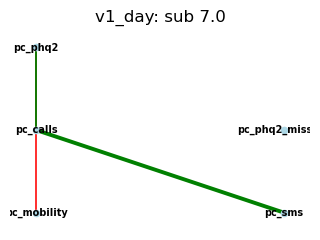

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


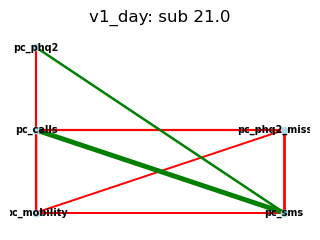

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


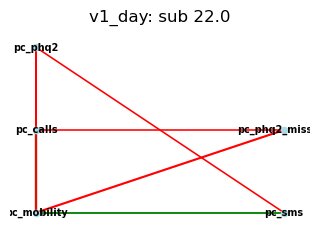

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


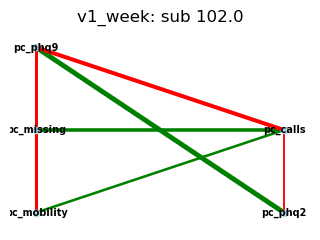

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


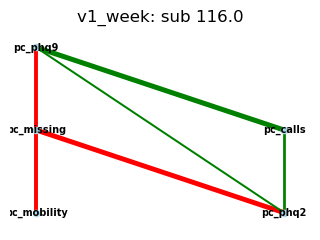

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


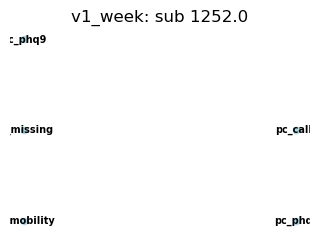

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


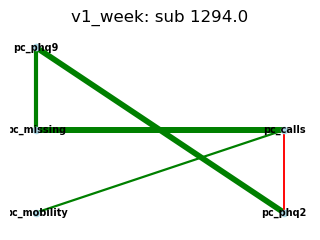

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


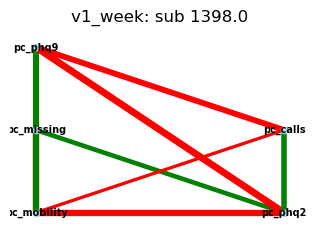

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


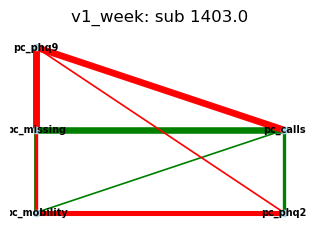

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


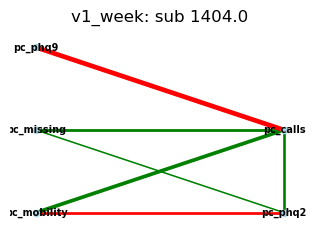

In [18]:
############ Plot subjects' individual networks of PCs ############

# Predefine fixed positions for nodes
fixed_positions_v1_day = {
    'pc_mobility': (1, 1),
    'pc_calls': (1, 2),
    'pc_sms': (2, 1),
    'pc_phq2': (1, 3),
    'pc_phq2_missing': (2, 2)
}

fixed_positions_v1_week = {
    'pc_missing': (1, 2),
    'pc_mobility': (1, 1),
    'pc_phq2': (2, 1),
    'pc_phq9': (1, 3),
    'pc_calls': (2, 2)
}


for name, df in dfs_pca.items():
    count, count2 = 0, 0
    
    cols=[col for col in df.columns.to_list() if 'pc_' in col]
    for sub in df['num_id'].unique():
        sub_df = df[df['num_id']==sub]
        if sub_df.shape[0] > 8:
            if count<7:
                if 'v1_day' in name:
                    fs.plot_network(sub_df, cols, title=f'{name}: sub {sub}', threshold=0.2, fixed_positions=fixed_positions_v1_day)
                    count+=1
            if count2<7:
                if 'v1_week' in name:
                    fs.plot_network(sub_df, cols, title=f'{name}: sub {sub}', threshold=0.2, fixed_positions=fixed_positions_v1_week)
                    count2+=1


## Checking for collinearity




For v1_day:


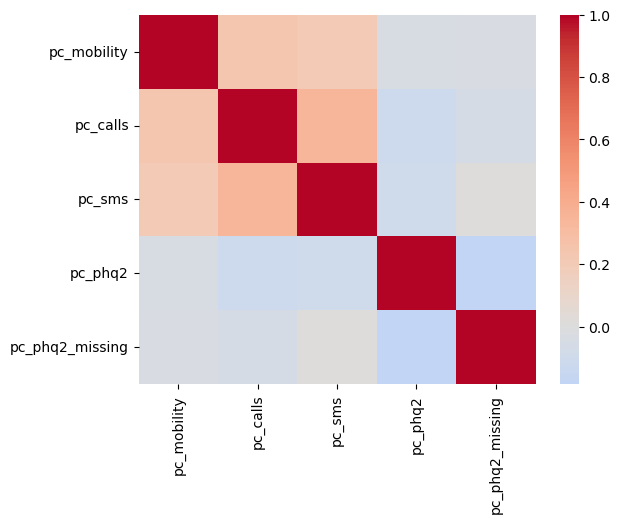



For v2_day:


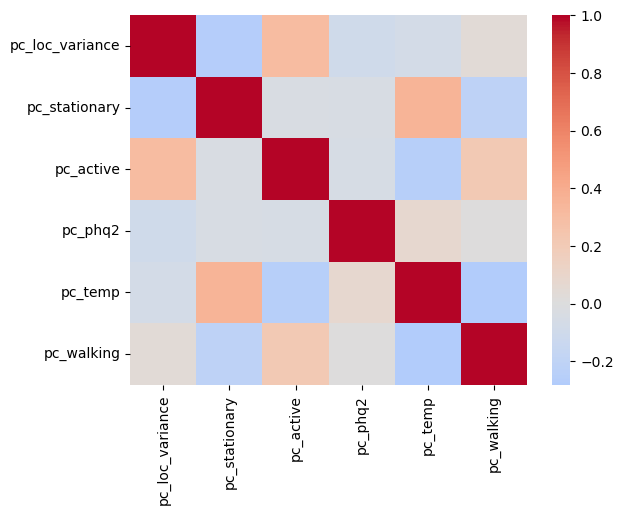



For v1_week:


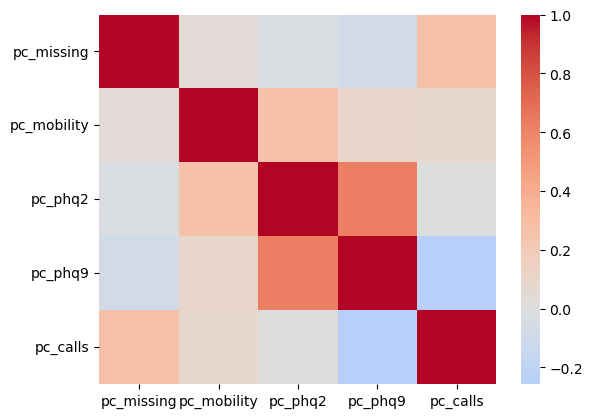



For v2_week:


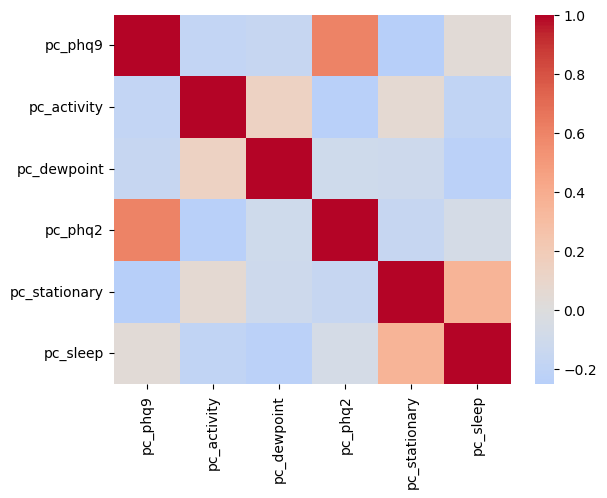

In [19]:
for name in df_names:
    df = pd.read_csv(os.path.join(brighten_dir, f'{name}_pca.csv'))
    print(f'\n\nFor {name}:')
    numeric_cols = [col for col in df.columns.to_list() if 'pc_' in col]
    sns.heatmap(df[numeric_cols].corr(), cmap="coolwarm", center=0)
    plt.show()

We can see that our features are successfull not correlated, except phq2 and phq9, which is expected, and in most cases, phq2 won't be used to predict phq9. 

In [59]:
# for name in df_names:
#     df = pd.read_csv(os.path.join(brighten_dir, f'{name}_pca.csv'))
#     print(f'\n\nFor {name}:')
#     numeric_cols = [col for col in df.columns.to_list() if col not in id_columns and col not in demographic_columns]
#     print('\nInvestigating Kurtosis:')
#     # Calculate kurtosis for numeric columns
#     kurtosis_values = df[numeric_cols].select_dtypes(include='number').apply(lambda x: kurtosis(x, fisher=True))
#     kurtosis_sorted = kurtosis_values.sort_values(ascending=False) # Sort by highest kurtosis
#     print(kurtosis_sorted) #display
    
#     for col in kurtosis_sorted.isna().index:
#         print(f'Kurtosis is NaN for {col}:')
#         print(df[col].nunique())      # Unique values
#         print(df[col].isna().sum())   # Missing values
#         print(df[col].describe())     # Summary stats


In [58]:
# for name in df_names:
#     df = pd.read_csv(os.path.join(brighten_dir, f'{name}_pca.csv'))
#     print(f'\n\nFor {name}:')
#     numeric_cols = [col for col in df.columns.to_list() if col not in id_columns and col not in demographic_columns]
#     print('\nInvestigating skew:')
#     print(df[numeric_cols].skew(numeric_only=True).sort_values(ascending=False)) # sort by highest, display    

In [ ]:
### Create lag variable
for name in df_names:
    df = pd.read_csv(os.path.join(brighten_dir, f'{name}_pca.csv'))
    print(f'\n\nFor {name}:')
    lag = phq9_cols + phq2_cols
    to_lag = [col for col in lag if col in df.columns]
    df_lag = pre.create_lag_variables(df, to_lag)
    df_lag.to_csv(os.path.join(brighten_dir, f'{name}_pca_lag.csv'), index=False)
    print(f"Saved {name}_pca_lag.csv to brighten_dir")





FOR v1_day, target_var: pc_phq2


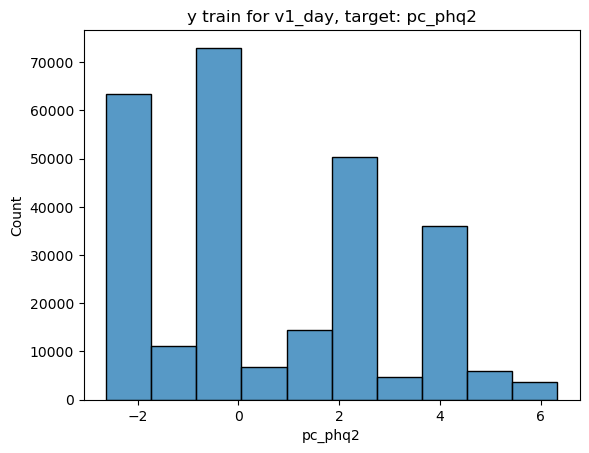

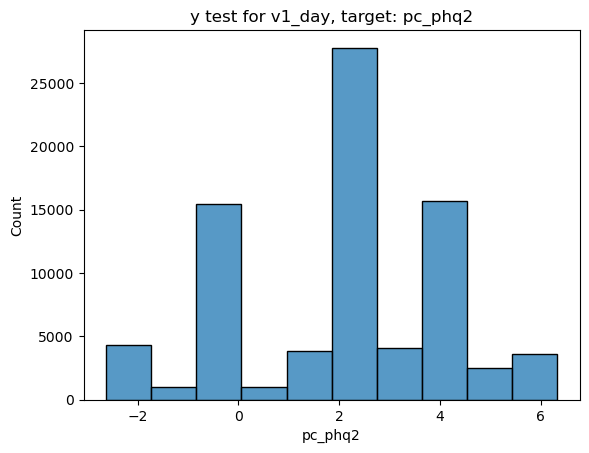



FOR v2_day, target_var: pc_phq2


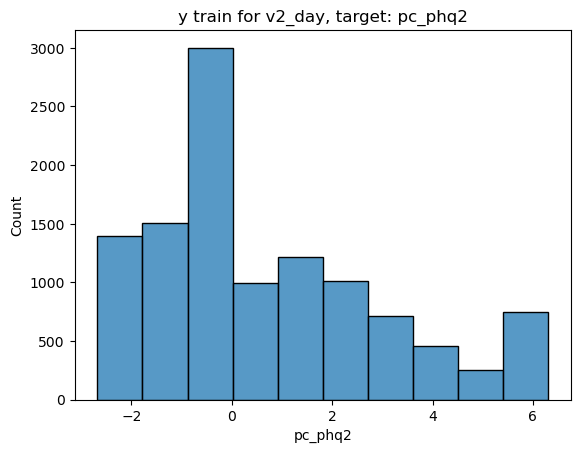

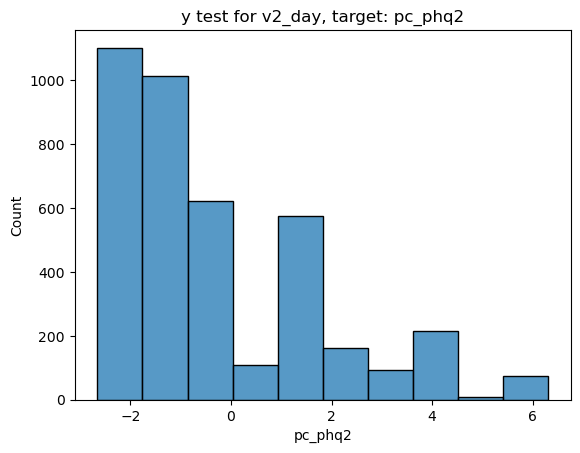



FOR v1_week, target_var: pc_phq9


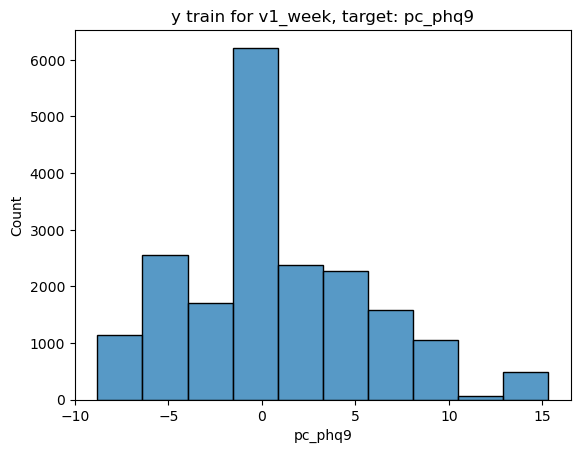

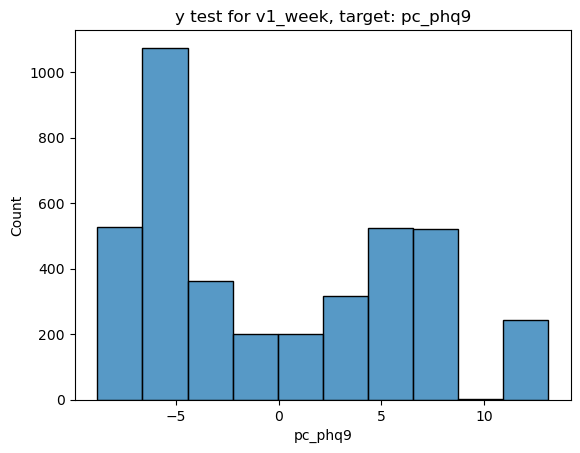



FOR v2_week, target_var: pc_phq9


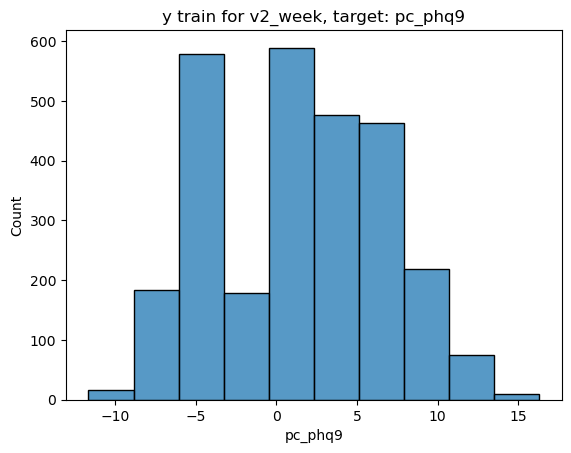

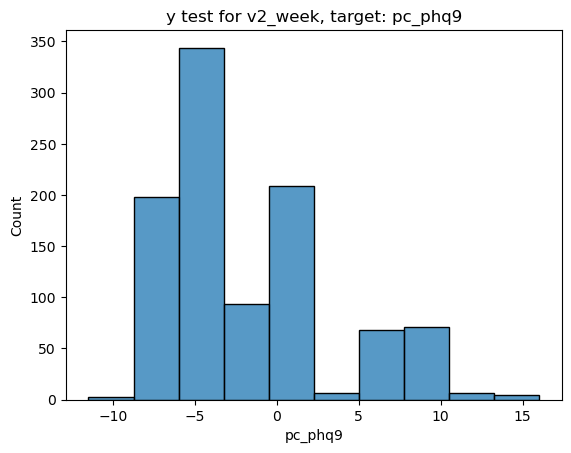

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit

for name in df_names:
    data_df = pd.read_csv(os.path.join(brighten_dir, f'{name}_pca.csv'))
    data_df = data_df.dropna()
    if not data_df.empty:
        if 'pc_phq9' in data_df.columns:
            target_var = 'pc_phq9'
        else:
            target_var = 'pc_phq2'
        print(f"\n\nFOR {name}, target_var: {target_var}")

        X = data_df.drop(columns=[col for col in data_df.columns if 'phq9' in col or 'phq2' in col]).copy()
        y = data_df[target_var].copy()

        gss = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
        groups = data_df['num_id'] # groups variable is based on num_id, so that no subjects are in train and test etc, 
        trainval_idx, test_idx = next(gss.split(X, y, groups=groups))

        # Get train/test sets
        X_trainval, X_test = X.iloc[trainval_idx], X.iloc[test_idx]
        y_trainval, y_test = y.iloc[trainval_idx], y.iloc[test_idx]

        gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
        groups_trainval = groups.iloc[trainval_idx]  # redefining groups to only include subs in traintest df
        train_idx, val_idx = next(gss.split(X_trainval, y_trainval, groups=groups_trainval))

        # Get train/test sets
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        X_test.to_csv(os.path.join(brighten_dir, f'{name}_pca_X_test.csv'))
        y_test.to_csv(os.path.join(brighten_dir, f'{name}_pca_y_test.csv'))
        X_train.to_csv(os.path.join(brighten_dir, f'{name}_pca_X_train.csv'))
        y_train.to_csv(os.path.join(brighten_dir, f'{name}_pca_y_train.csv'))
        X_val.to_csv(os.path.join(brighten_dir, f'{name}_pca_X_val.csv'))
        y_val.to_csv(os.path.join(brighten_dir, f'{name}_pca_y_val.csv'))


        # # Create hisogram for target value
        # sns.histplot(y_val, bins=10)
        # plt.title(f'y val for {name}, target: {target_var}')
        # plt.show()

        # Create hisogram for target value
        sns.histplot(y_train, bins=10)
        plt.title(f'y train for {name}, target: {target_var}')
        plt.show()

        # Create hisogram for target value
        sns.histplot(y_test, bins=10)
        plt.title(f'y test for {name}, target: {target_var}')
        plt.show()
